# COSMIC
Code to generate figure3 + associated supplementary results

## Reqs
To run this notebook you have to download / get following file in addition to the files already present in the repository :
- `rawdata/COSMIC_v3.4_SBS_GRCh38.txt` # Follow instruction in `rawdata/get_files.md`

In [2]:
GENERATE_RESULTS = True # if set to true it will generate results in outputs/ directory.

import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sbs
from pathlib import Path
import numpy as np
from scipy import stats
import matplotlib.patches as mpatches
from utils.utils import (
    get_pyrimidine_strand,
    print_markdown,
    VIPER
)
import utils.load_data as load_data

fontdict = {"size": 14, "family": "sans-serif"}
mpl.rc("font", **fontdict)

## Notebook's specific functions

In [3]:
def plot_cosmic_signature_correlations(
    stat_method,
    df,
    categories=None,
    colors_map=None,
    output_name=None,
    transparent_background=False,
    title=None,
):
    """
    Plot COSMIC signature correlations as a bar chart.

    Parameters
    ----------
    stat_method : str
        Statistical method to use: "pearson" or "spearman"
    df : pl.DataFrame
        DataFrame containing signature, classification, and correlation statistics
    categories : list, optional
        List of classification categories to include in the plot.
        Default: ["DNA repair", "Electrophilic", "UV-Light", "Other"]
        Can also include "Unknown" and "artefact"
    colors_map : dict, optional
        Dictionary mapping classification to colors. If provided, overrides default colors.
    output_name : str, optional
        If provided and GENERATE_RESULTS is True, saves the figure to
        PROJECT_DIR / "outputs" / output_name.svg
    """
    # Default categories if not provided
    if categories is None:
        categories = ["DNA repair", "Electrophilic", "UV-Light", "Other"]

    # Default colors if not provided
    if colors_map is None:
        default_colors = {
            "DNA repair": mpl.cm.tab20c(6),
            "Electrophilic": mpl.cm.tab20c(4),
            "UV-Light": mpl.cm.tab20c(14),
            "Other": mpl.cm.tab20c(0),
            "Unknown": mpl.cm.tab20c(19),
            "artefact": mpl.cm.tab20c(2)
        }
        colors_map = {cat: default_colors[cat] for cat in categories if cat in default_colors}

    # Determine p-value column based on stat method
    p_val_col = {"pearson": "pvalue_p", "spearman": "pvalue_s"}[stat_method]

    # Filter dataframe to include only specified categories and sort
    filtered_df = df.filter(pl.col('classification').is_in(categories)).sort(pl.col(stat_method))

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.grid(False)

    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Map colors to classifications
    colors_list = [
        colors_map[classification] for classification in filtered_df["classification"]
    ]

    # Create bar plot
    bars = ax.bar(
        filtered_df["signature"].str.replace('SBS', ''),
        filtered_df[stat_method],
        color=colors_list
    )

    # Add signature labels and asterisks for significant p-values
    for i, (bar, signature, stat, pval) in enumerate(
        zip(bars,
            filtered_df["signature"].str.replace('SBS', ''),
            filtered_df[stat_method],
            filtered_df[p_val_col])
    ):
        # Add signature label
        if stat >= 0:
            vertical_alignment = "top"
            vertical_offset = 0
        else:
            vertical_alignment = "bottom"
            vertical_offset = 0.01
        ax.text(
            bar.get_x() + bar.get_width()/2,
            vertical_offset,
            signature,
            ha="center",
            va=vertical_alignment,
            fontsize=10,
            rotation=90
        )

        # Add asterisk if p-value <= 0.05
        if pval <= 0.05:
            if stat >= 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    stat,
                    '*',
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    fontweight='bold'
                )
            else:
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    stat - 0.01,
                    '*',
                    ha="center",
                    va="top",
                    fontsize=8,
                    fontweight='bold'
                )

    # Add legend
    legend_patches = [
        mpatches.Patch(color=color, label=classification)
        for classification, color in colors_map.items()
    ]
    ax.legend(handles=legend_patches)
    if title:
        ax.set_title(title)

    # Style axes
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set ylabel based on stat method
    ylabel = r"$r(\overline{F}, \overline{vIP})$" if stat_method == "pearson" else r"$\rho(\overline{F}, \overline{vIP})$"
    ax.set_ylabel(ylabel)
    ax.set_xticks([])

    # Save figure if output_name is provided and GENERATE_RESULTS is True
    if output_name is not None and GENERATE_RESULTS:
        output_path = PROJECT_DIR / "outputs" / f"{output_name}"
        if not output_path.parent.exists():
            output_path.parent.mkdir(parents=True)
        fig.savefig(output_path, bbox_inches='tight', transparent=transparent_background)
        print(f"Figure saved to {output_path}")

    plt.show()

def get_corr_df(df, xs, y='vip' ) -> pl.DataFrame:
    correlations = {"signature": [], "pearson": [], "pvalue_p": [], "spearman": [], "pvalue_s": []}

    for col in xs:
        correlations["signature"].append(col)
        stat, pvalue = stats.pearsonr(df[col], df["vip"])
        correlations["pearson"].append(stat)
        correlations["pvalue_p"].append(pvalue)
        stat, pvalue = stats.spearmanr(df[col], df["vip"])
        correlations["spearman"].append(stat)
        correlations["pvalue_s"].append(pvalue)

    return pl.DataFrame(correlations)

# Load Dataset

In [4]:
PROJECT_DIR = Path().absolute().parent
kmer_context = load_data.get_kmer_df(PROJECT_DIR / "hg38", 3)["context", "total"]

signature_etiology = pl.read_csv(
    PROJECT_DIR / "data" /"cosmic"/"cosmic_sbs_etiologies.tsv", separator="\t"
)

cosmic_signatures_df = pl.read_csv(
    PROJECT_DIR / "rawdata" / "COSMIC_v3.4_SBS_GRCh38.txt", separator="\t"
).with_columns(
    pl.col("Type")
    .map_elements(lambda x: f"{x[0]}{x[2]}{x[-1]}", return_dtype=pl.Utf8)
    .alias("context"),
    pl.col("Type").str.slice(2, 1).alias("ref"),
    pl.col("Type").str.slice(4, 1).alias("alt"),
)

## Figure 3 (aggregated data)

In [5]:
kmer_context_bar = (kmer_context.group_by(
        pl.col("context").map_elements(
            get_pyrimidine_strand, return_dtype=pl.Utf8
        )
    ).agg(pl.col("total").sum())
    .with_columns(frequencies=pl.col("total") / pl.col("total").sum()))

cosmic_signatures_df_bar = cosmic_signatures_df.group_by(
    pl.col("context").map_elements(
        get_pyrimidine_strand, return_dtype=pl.Utf8
    )
).agg(pl.exclude("Type", "ref", "alt").mean()).join(kmer_context_bar, on="context").with_columns(
    pl.col('context').map_elements(VIPER.compute_double_strand_score, return_dtype=pl.Float64).alias('vip')
).with_columns(np.log(pl.exclude('context', 'total', 'frequencies', 'vip')/pl.col('frequencies')))

signature_correlation_bar = get_corr_df(
    cosmic_signatures_df_bar, cosmic_signatures_df_bar.select(
        pl.all().exclude(["context", "total", "frequencies", "vip"])).columns )


In [6]:
print_markdown(signature_correlation_bar)

ModuleNotFoundError: No module named 'pyarrow'

In [7]:
signature_stats = signature_etiology.join(signature_correlation_bar, on="signature")
if GENERATE_RESULTS:
    signature_stats.write_csv(PROJECT_DIR / "outputs" / "cosmic_sbs_etiologies_stats.tsv", separator="\t")

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic_sbs_etiologies_pearson.svg


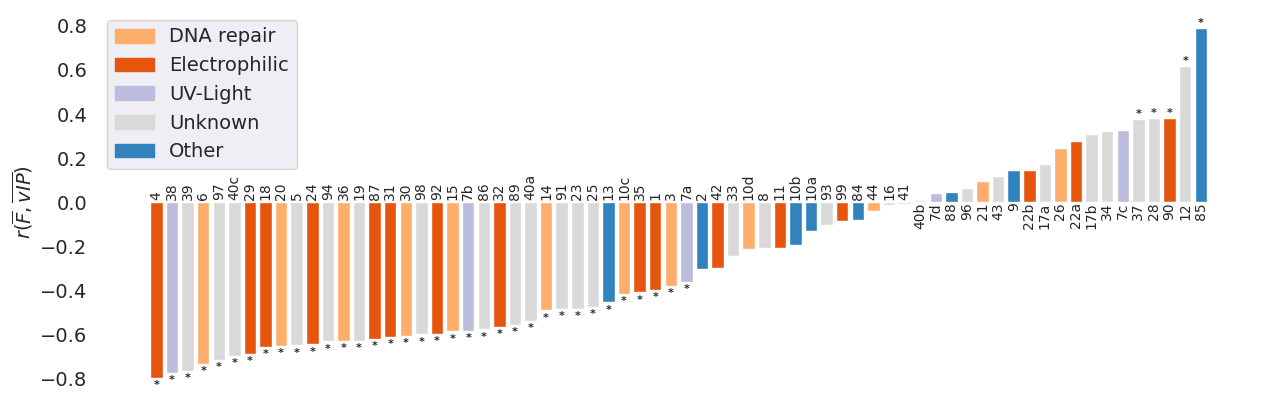

In [8]:

plot_cosmic_signature_correlations(stat_method="pearson",
                                   df=signature_stats,
                                   categories=["DNA repair", "Electrophilic", "UV-Light", "Unknown", "Other"],
                                   output_name="cosmic_sbs_etiologies_pearson.svg",
                                   transparent_background=False
                                   )

## Supplementary xx (type of SBS)


Figure saved to /home/ben/projects/vIP/paper/outputs/supplementary/cosmic/T>G.svg


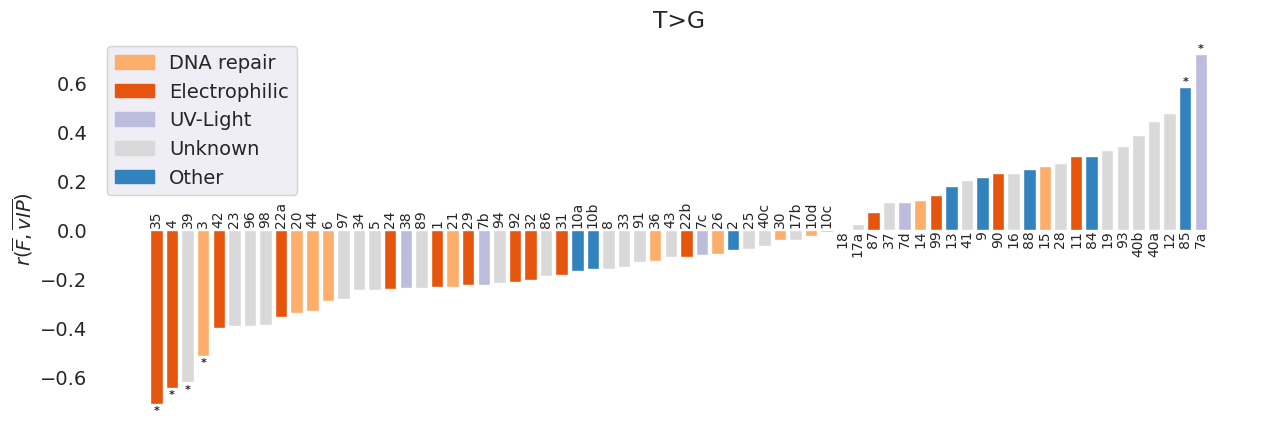

Figure saved to /home/ben/projects/vIP/paper/outputs/supplementary/cosmic/C>T.svg


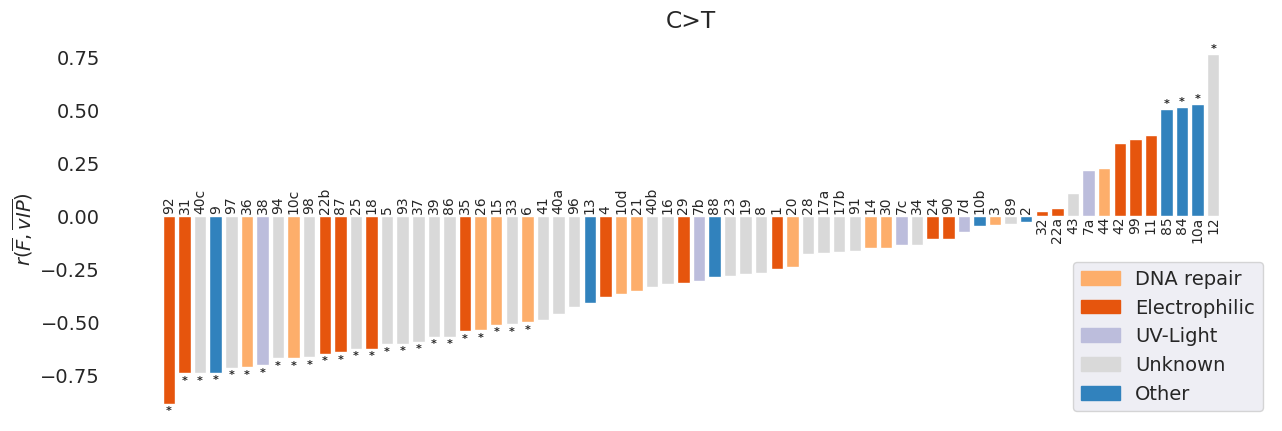

Figure saved to /home/ben/projects/vIP/paper/outputs/supplementary/cosmic/C>G.svg


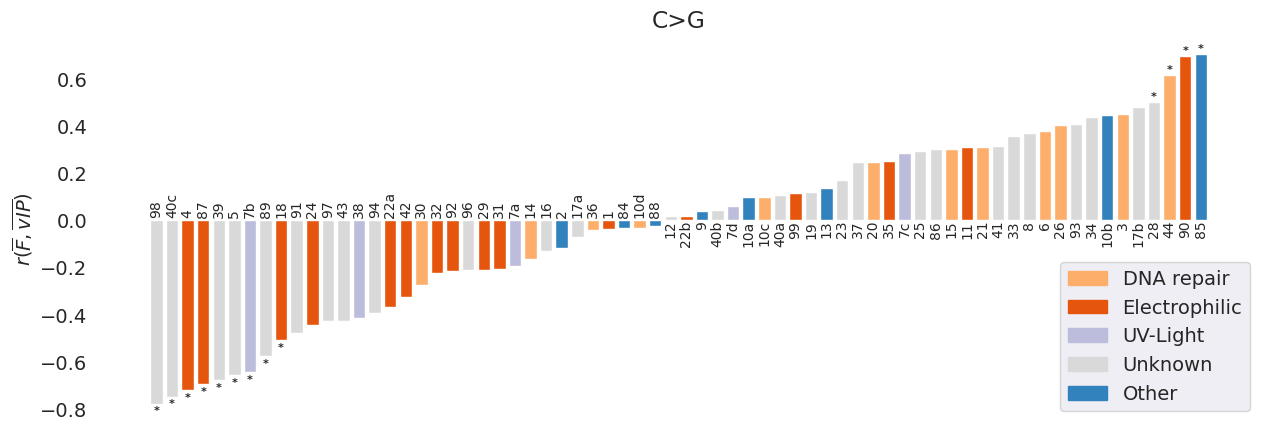

Figure saved to /home/ben/projects/vIP/paper/outputs/supplementary/cosmic/T>C.svg


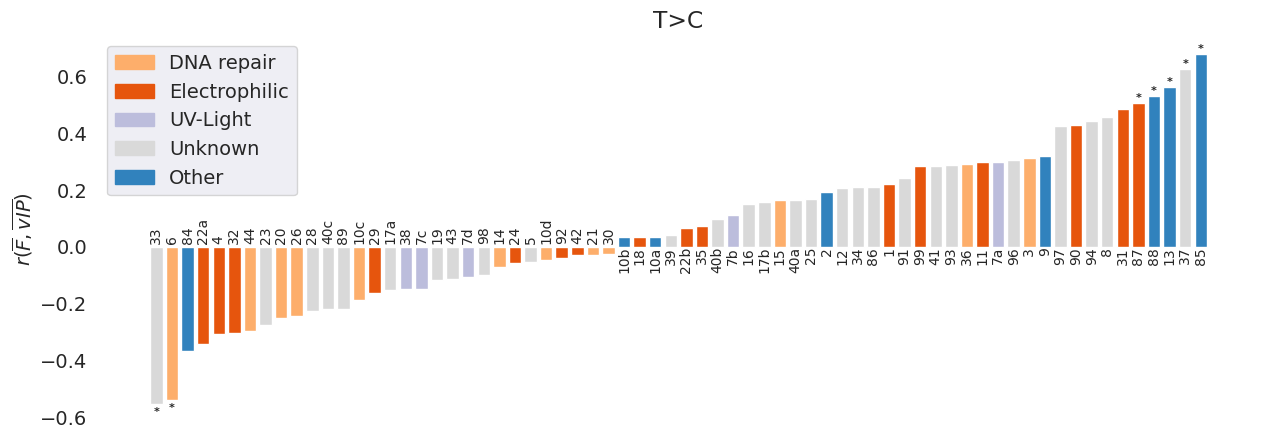

Figure saved to /home/ben/projects/vIP/paper/outputs/supplementary/cosmic/T>A.svg


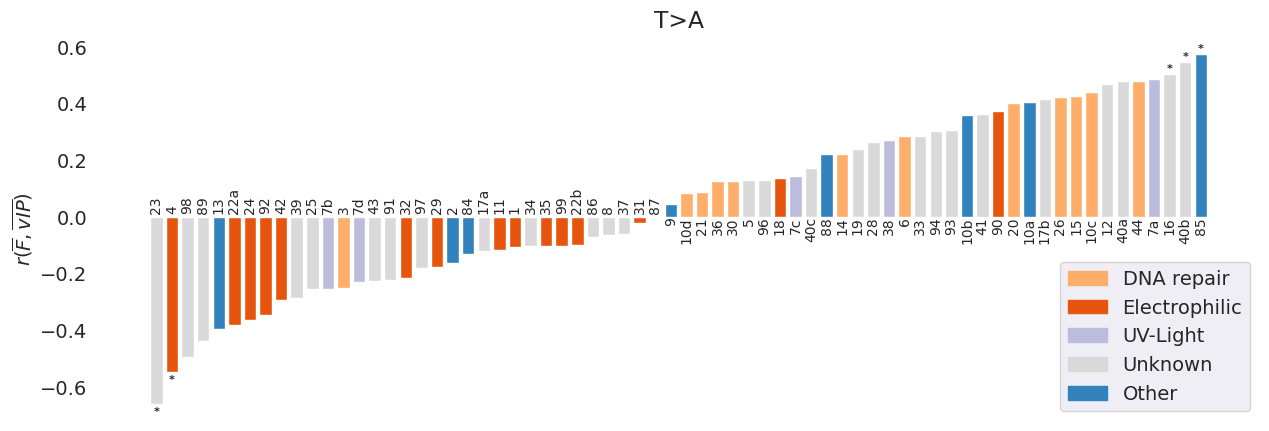

Figure saved to /home/ben/projects/vIP/paper/outputs/supplementary/cosmic/C>A.svg


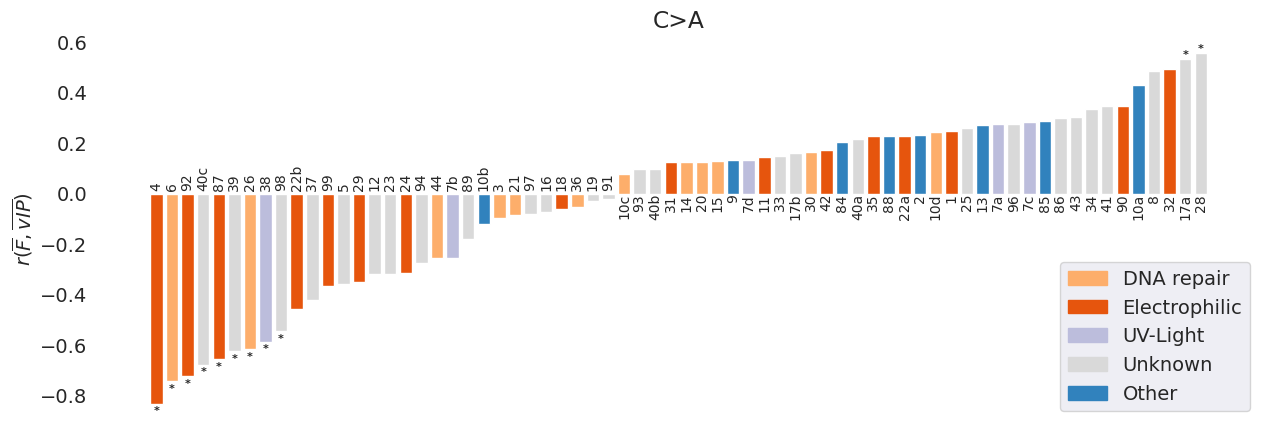

In [9]:
corr_dfs = []

for ref, alt in cosmic_signatures_df.select(['ref', 'alt']).unique().iter_rows():
    alt_corr = (
        cosmic_signatures_df
        .filter(pl.col("alt") == alt, pl.col('ref') == ref)
        .join(kmer_context_bar, on="context")
        .with_columns(
            pl.col('context').map_elements(VIPER.compute_double_strand_score, return_dtype=pl.Float64).alias('vip')
        )
        .with_columns(np.log(pl.exclude('Type', 'ref', 'alt', 'context', 'total', 'frequencies', 'vip') / pl.col('frequencies')))
    )

    alt_corr = get_corr_df(alt_corr, xs=alt_corr.select(pl.exclude("Type", "ref", "alt", "context", "total", "frequencies", "vip")).columns)
    corr_dfs.append(alt_corr.with_columns(pl.lit(f'{ref}>{alt}').alias('sbs_type')))

    plot_cosmic_signature_correlations(
        stat_method="pearson",
        df=signature_etiology.join(alt_corr, on="signature"),
        categories=["DNA repair", "Electrophilic", "UV-Light", "Unknown", "Other"],
        transparent_background=False,
        title=f"{ref}>{alt}",
        output_name=f"supplementary/cosmic/{ref}>{alt}.svg"
    )

corr_decomposition = pl.concat(corr_dfs)


Figure saved to /home/ben/projects/vIP/paper/outputs/supplementary/cosmic/SBS_type_heatmap.svg


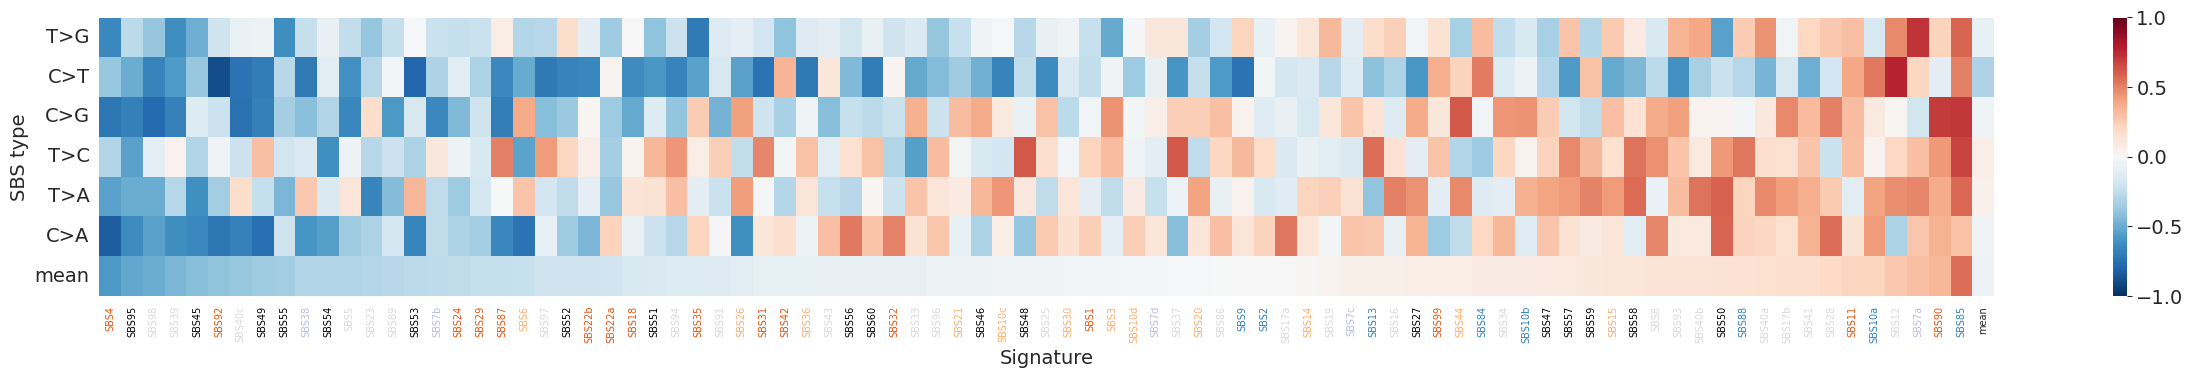

In [10]:
pivot = corr_decomposition.pivot(values="pearson", index="sbs_type", on="signature")
types = pivot["sbs_type"].to_list()
signatures = [c for c in pivot.columns if c != "sbs_type"]
matrix = pivot.select(signatures).to_numpy()

# Sort signatures by mean pearson across types
mean_per_sig = matrix.mean(axis=0)
order = np.argsort(mean_per_sig)
matrix = matrix[:, order]
signatures = [signatures[i] for i in order]

# Append mean column (horizontal mean per sbs_type)
mean_per_type = matrix.mean(axis=1)
matrix_with_col = np.hstack([matrix, mean_per_type.reshape(-1, 1)])

# Append mean row (vertical mean per signature + grand mean)
mean_row = np.append(mean_per_sig[order], mean_per_type.mean()).reshape(1, -1)
full_matrix = np.vstack([matrix_with_col, mean_row])

xticks = signatures + ["mean"]
yticks = types + ["mean"]

etiology_colors = {
    "DNA repair":    mpl.cm.tab20c(6),
    "Electrophilic": mpl.cm.tab20c(4),
    "UV-Light":      mpl.cm.tab20c(14),
    "Other":         mpl.cm.tab20c(0),
    "Unknown":       mpl.cm.tab20c(19),
    "artefact":      mpl.cm.tab20c(2),
}
sig_to_classification = dict(signature_etiology.select(["signature", "classification"]).iter_rows())

fig, ax = plt.subplots(figsize=(25, 4))
sbs.heatmap(
    full_matrix,
    xticklabels=xticks,
    yticklabels=yticks,
    cmap="RdBu_r",
    center=0,
    vmin=-1, vmax=1,
    linewidths=0,
    ax=ax,
)
ax.tick_params(axis="x", rotation=90, labelsize=7)
ax.set_xlabel("Signature")
ax.set_ylabel("SBS type")

for label in ax.get_xticklabels():
    sig = label.get_text()
    classification = sig_to_classification.get(sig)
    if classification is not None:
        label.set_color(etiology_colors.get(classification, "black"))

plt.tight_layout()
if GENERATE_RESULTS:
    output_path = PROJECT_DIR / "outputs" / "supplementary" / "cosmic" /  f"SBS_type_heatmap.svg"
    if not output_path.parent.exists():
        output_path.parent.mkdir(parents=True)
    fig.savefig(output_path, bbox_inches='tight', transparent=False)
    print(f"Figure saved to {output_path}")
plt.show()


Figure saved to /home/ben/projects/vIP/paper/outputs/supplementary/cosmic/mean_sbs_category.svg


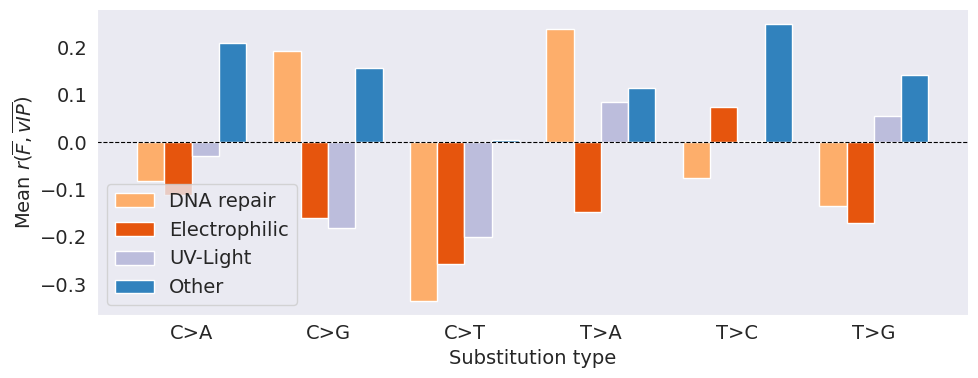

In [11]:
categories = ["DNA repair", "Electrophilic", "UV-Light", "Other"]


mean_df = (
    corr_decomposition
    .join(signature_etiology, on="signature")
    .filter(pl.col("classification").is_in(categories))
    .group_by(["sbs_type", "classification"])
    .agg(pl.col("pearson").mean())
)

sbs_types = sorted(mean_df["sbs_type"].unique().to_list())
n_cats = len(categories)
width = 0.8 / n_cats
x = np.arange(len(sbs_types))
offsets = np.linspace(-(n_cats - 1) / 2, (n_cats - 1) / 2, n_cats) * width

fig, ax = plt.subplots(figsize=(10, 4))
for offset, cat in zip(offsets, categories):
    cat_df = mean_df.filter(pl.col("classification") == cat)
    heights = [
        cat_df.filter(pl.col("sbs_type") == t)["pearson"].item()
        if t in cat_df["sbs_type"].to_list() else float("nan")
        for t in sbs_types
    ]
    ax.bar(x + offset, heights, width=width, label=cat, color=etiology_colors[cat])

ax.set_xticks(x)
ax.set_xticklabels(sbs_types)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax.set_ylabel(r"Mean $r(\overline{F}, \overline{vIP})$")
ax.set_xlabel("Substitution type")
ax.legend()
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
if GENERATE_RESULTS:
    output_path = PROJECT_DIR / "outputs" / "supplementary" / "cosmic" /  f"mean_sbs_category.svg"
    if not output_path.parent.exists():
        output_path.parent.mkdir(parents=True)
    fig.savefig(output_path, bbox_inches='tight', transparent=False)
    print(f"Figure saved to {output_path}")
plt.show()
